In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import f1_score

Data Handling 

In [2]:
import os
import cv2
import numpy as np

def get_data(type="train"):
    data = []
    label = []
    for i in range(1, 37):
        X = []
        y = []
        target = f"{i:02d}"  
        train_data_path = f"data/q2/{type}/{target}"
        
        for img_name in os.listdir(train_data_path):
            img_path = os.path.join(train_data_path, img_name)
            
            
            img = cv2.imread(img_path)
            
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            
            img = cv2.resize(img, (32, 32))
            img = img / 255.0 
            img_flatten = img.flatten()
            X.append(img_flatten)
            y.append(i)

        data.extend(X)
        label.extend(y)

    data = np.array(data)
    label = np.array(label)
    return data, label


In [3]:
X_train , y_train = get_data("train")
X_test , y_test = get_data("test")
y_train  = np.eye(36)[y_train - 1]
y_test  = np.eye(36)[y_test - 1]

Perceptron 

In [4]:


class Layer:
    def __init__(self,in_dimension , out_dimension , learning_rate = 0.001 , is_sigmoid = True,is_output = False):
        self.net_grad = None
        self.lr = learning_rate
        self.O = None
        limit = np.sqrt(6 / (in_dimension + out_dimension))
        self.w = np.random.uniform(-limit, limit, (in_dimension + 1, out_dimension))

        self.output_function = self.__sigmoid if is_sigmoid else self.__softmax
        self.is_output = is_output

    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def __softmax(self,x):
        exp_x = np.exp(x - np.max(x , axis =1 , keepdims=True))
        return exp_x / np.sum(exp_x, axis = 1 , keepdims=True)

    def __sigmoid_grad(self,x):
        return x * (1-x)    

    def next(self,X ):
        X = np.hstack([np.ones((X.shape[0] , 1)),X])
        self.net_grad = np.dot(X, self.w)
        self.O = self.output_function(self.net_grad)
        return self.O

    def _prev(self, dO , O_down):
        if not self.is_output:
            new_grad = dO * self.__sigmoid_grad(self.O)
            dw = np.dot(np.hstack([np.ones((O_down.shape[0], 1)), O_down]).T , new_grad) / O_down.shape[0]
            d_O_down = np.dot(new_grad , self.w.T)
            dO_prev =   d_O_down[:,1:]
            self.w = self.w - self.lr * dw
            return  dO_prev
        
            
    

class FinalLayer :
    def __init__(self,in_dim , out_dim , lr = 0.001 ,is_softmax = True) :
        self.lr = lr
        limit = np.sqrt(6 / (in_dim + out_dim))
        self.w = np.random.uniform(-limit, limit, (in_dim + 1, out_dim))

        self.net_grad = None
        self.O = None
        self.output_function = self.__softmax if is_softmax else self.__sigmoid

    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def __softmax(self,x):
        exp_x = np.exp(x - np.max(x , axis =1 , keepdims=True))
        return exp_x / np.sum(exp_x, axis = 1 , keepdims=True)

    def __sigmoid_grad(self,x):
        return x * (1-x)  

    def next(self , X) :
        X = np.hstack([np.ones((X.shape[0] , 1)),X ])    
        self.net_grad = np.dot(X, self.w)
        self.O = self.output_function(self.net_grad)
        return self.O
    
    def _prev(self, y_true , O_down)  :
        new_grad = self.O - y_true
        dw = np.dot(np.hstack([np.ones((O_down.shape[0], 1)), O_down]).T , new_grad) / y_true.shape[0]
        d_O_down = np.dot(new_grad , self.w.T)
        dO_prev =   d_O_down[:,1:]
        self.w = self.w - self.lr * dw
        return dO_prev
    
class NeuralNetwork:
    def __init__(self, M = 32 , n = 3072 , HiddenLayer = [512 , 265 ]  , target_class = 36 , lr = 0.01):
        self.lr = lr
        self.layers = []
        self.Batch_size = M
        prev_dimn = n
        for h in HiddenLayer:
            layer = Layer(prev_dimn , h , is_sigmoid = True , learning_rate = self.lr)
            self.layers.append(layer)
            prev_dimn = h
        self.output_layer = FinalLayer(prev_dimn , target_class , is_softmax = True , lr = self.lr)

    def next(self,X) : 
        O_down = X 
        for layer in self.layers :
            O_down = layer.next(O_down)

        predictions = self.output_layer.next(O_down)
        return predictions
    
    def corss_entropy_loss(self, y_true , y_pred):
        m = y_true.shape[0]
        return - np.sum(y_true * np.log(y_pred + 1e-10 )) / m
     
    def _prev(self,Y , X) : 
        O = X 
        stored_outputs = [X]
        for layer in self.layers :
            O = layer.next(O)
            stored_outputs.append(O)
        predictions = self.output_layer.next(O)

       

        do_down = self.output_layer._prev(Y , stored_outputs[-1])
        for i in range(len(self.layers)-1 , -1 , -1):
            do_down = self.layers[i]._prev(do_down , stored_outputs[i])

        return predictions  

    def predict(self,X) :
        predictions = self.next(X)
        return np.argmax(predictions , axis = 1)   
    
    def fit(self , X , Y , epochs = 10 ):
        for epoch in range(epochs) : 
            comb = np.random.permutation(X.shape[0])
            X_shuffled = X[comb]
            Y_shuffled = Y[comb]
            J = 0

            for i in range(0, X.shape[0] , self.Batch_size):
                X_batch = X_shuffled[i : i + self.Batch_size]
                Y_batch = Y_shuffled[i : i + self.Batch_size]
                predictions = self._prev(Y_batch , X_batch)
                loss = self.corss_entropy_loss(Y_batch , predictions)
                J += loss
           
            print(f"Epoch {epoch + 1} / {epochs} , Loss : {J}")

               


In [38]:
model = NeuralNetwork(M = 32 , n = 3072 , HiddenLayer = [512 , 265 ]  , target_class = 36) 
model.fit(X_train , y_train , epochs = 40)

Epoch 1 / 40 , Loss : 2409.2260649951395
Epoch 2 / 40 , Loss : 2352.690445946514
Epoch 3 / 40 , Loss : 2284.5034127556746
Epoch 4 / 40 , Loss : 2185.0189945715047
Epoch 5 / 40 , Loss : 2050.343502056293
Epoch 6 / 40 , Loss : 1895.3162494674878
Epoch 7 / 40 , Loss : 1745.271929570783
Epoch 8 / 40 , Loss : 1610.2060360356575
Epoch 9 / 40 , Loss : 1493.668258879202
Epoch 10 / 40 , Loss : 1394.0021078690725
Epoch 11 / 40 , Loss : 1308.76394627451
Epoch 12 / 40 , Loss : 1237.9929297539309
Epoch 13 / 40 , Loss : 1178.94935483754
Epoch 14 / 40 , Loss : 1129.728854652895
Epoch 15 / 40 , Loss : 1088.6353222242217
Epoch 16 / 40 , Loss : 1054.090937004183
Epoch 17 / 40 , Loss : 1024.0412185376429
Epoch 18 / 40 , Loss : 998.4419160644235
Epoch 19 / 40 , Loss : 975.9303788167264
Epoch 20 / 40 , Loss : 955.9037674220816
Epoch 21 / 40 , Loss : 937.6590348950805
Epoch 22 / 40 , Loss : 921.4122868125509
Epoch 23 / 40 , Loss : 906.1927614164491
Epoch 24 / 40 , Loss : 892.5320170162543
Epoch 25 / 40 , Lo

In [5]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

hidden_layer_length = [1, 5, 10, 50, 100]

for h_len in hidden_layer_length:
    print(f"\n=== Hidden layer size: {h_len} ===")

    model = NeuralNetwork(M=32, n=3072, HiddenLayer=[h_len], target_class=36, lr=0.01)
    model.fit(X_train, y_train, epochs=200)

    y_test_prediction = model.predict(X_test)
    y_train_prediction = model.predict(X_train)

    print("\nAccuracy:")
    print(f"Train Accuracy: {np.mean(y_train_prediction == np.argmax(y_train, axis=1)) * 100:.2f}%")
    print(f"Test Accuracy: {np.mean(y_test_prediction == np.argmax(y_test, axis=1)) * 100:.2f}%")

    # ---------- METRIC FUNCTION ----------
    def results_metrics(y_true, y_pred):
        y_true_labels = np.argmax(y_true, axis=1)
        f1 = f1_score(y_true_labels, y_pred, average=None)
        precision = precision_score(y_true_labels, y_pred, average=None, zero_division=0)
        recall = recall_score(y_true_labels, y_pred, average=None, zero_division=0)
        return f1, precision, recall

    # ---------- TEST SET ----------
    f1_test, precision_test, recall_test = results_metrics(y_test, y_test_prediction)
    results_test = pd.DataFrame({
        "Class": np.arange(1, len(f1_test) + 1),
        "F1": f1_test,
        "Precision": precision_test,
        "Recall": recall_test
    })

    print("\nPer-Class Metrics (Test):")
    print(results_test.round(4).to_string(index=False))

    print("\nAverage (Macro) Metrics (Test):")
    print(f"F1: {np.mean(f1_test):.4f}, Precision: {np.mean(precision_test):.4f}, Recall: {np.mean(recall_test):.4f}")

    print("---------------------------------------------------")

    # ---------- TRAIN SET ----------
    f1_train, precision_train, recall_train = results_metrics(y_train, y_train_prediction)
    results_train = pd.DataFrame({
        "Class": np.arange(1, len(f1_train) + 1),
        "F1": f1_train,
        "Precision": precision_train,
        "Recall": recall_train
    })

    print("\nPer-Class Metrics (Train):")
    print(results_train.round(4).to_string(index=False))

    print("\nAverage (Macro) Metrics (Train):")
    print(f"F1: {np.mean(f1_train):.4f}, Precision: {np.mean(precision_train):.4f}, Recall: {np.mean(recall_train):.4f}")

    print("===================================================")




=== Hidden layer size: 1 ===
Epoch 1 / 200 , Loss : 2426.437714335293
Epoch 2 / 200 , Loss : 2410.071257007787
Epoch 3 / 200 , Loss : 2398.2718749550168
Epoch 4 / 200 , Loss : 2388.2231032576406
Epoch 5 / 200 , Loss : 2379.2867552347543
Epoch 6 / 200 , Loss : 2371.1355506258483
Epoch 7 / 200 , Loss : 2363.558830812137
Epoch 8 / 200 , Loss : 2356.4375748886564
Epoch 9 / 200 , Loss : 2349.700468851641
Epoch 10 / 200 , Loss : 2343.2710583316225
Epoch 11 / 200 , Loss : 2337.1181527663543
Epoch 12 / 200 , Loss : 2331.2683094492563
Epoch 13 / 200 , Loss : 2325.667756978265
Epoch 14 / 200 , Loss : 2320.269253991931
Epoch 15 / 200 , Loss : 2315.1111950771046
Epoch 16 / 200 , Loss : 2310.1977803668224
Epoch 17 / 200 , Loss : 2305.4472060990092
Epoch 18 / 200 , Loss : 2300.9288172219076
Epoch 19 / 200 , Loss : 2296.596022632107
Epoch 20 / 200 , Loss : 2292.439050285678
Epoch 21 / 200 , Loss : 2288.5090266907105
Epoch 22 / 200 , Loss : 2284.6751249569293
Epoch 23 / 200 , Loss : 2281.033505861923

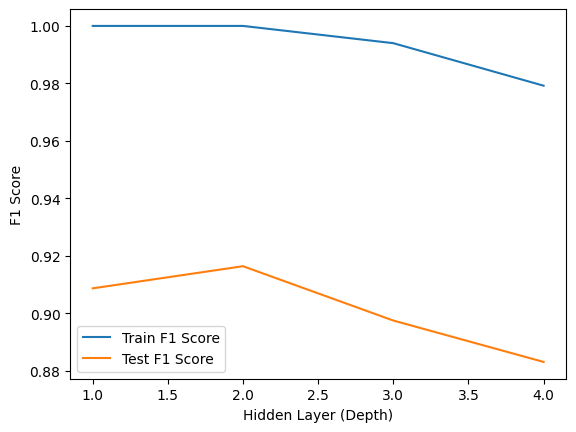

In [6]:
Average_Test_F1 = [0.9087,0.9164,0.8975,0.8831]
Average_Train_F1 = [1,1,0.9940,0.9792]
hidden_layer = [1,2,3,4]
plt.plot(hidden_layer , Average_Train_F1 , label = "Train F1 Score")
plt.plot(hidden_layer , Average_Test_F1 , label = "Test F1 Score")
plt.xlabel("Hidden Layer (Depth)")
plt.ylabel("F1 Score")
plt.legend()
plt.show()